## <b><u> Exploratory Data Analysis </u></b>
### As usual, it is prudent to begin with some basic exploratory analysis.

In [ ]:
import numpy as np
import pandas as pd
from IPython.display import display
from tqdm import tqdm
from collections import Counter
import ast

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sb

from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
import scipy.stats as stats

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE



%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
datafile = '/content/driv.csv'
raw_data = pd.read_csv(datafile, parse_dates=[0], infer_datetime_format=True)

reindexed_data = raw_data['headline_text']
reindexed_data.index = raw_data['publish_date']

raw_data.head()

,publish_date,headline_text
0,2003-02-19,aba decides against community broadcasting lic...
1,2003-02-19,act fire witnesses must be aware of defamation
2,2003-02-19,a g calls for infrastructure protection summit
3,2003-02-19,air nz staff in aust strike for pay rise
4,2003-02-19,air nz strike to affect australian travellers


### First we develop a list of the top words used across all one million headlines, giving us a glimpse into the core vocabulary of the source data. Stop words are omitted here to avoid any trivial conjunctions, prepositions, etc.

In [ ]:
# Define helper functions
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    '''
    returns a tuple of the top n words in a sample and their 
    accompanying counts, given a CountVectorizer object and text sample
    '''
    vectorized_headlines = count_vectorizer.fit_transform(text_data.values)
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for 
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])

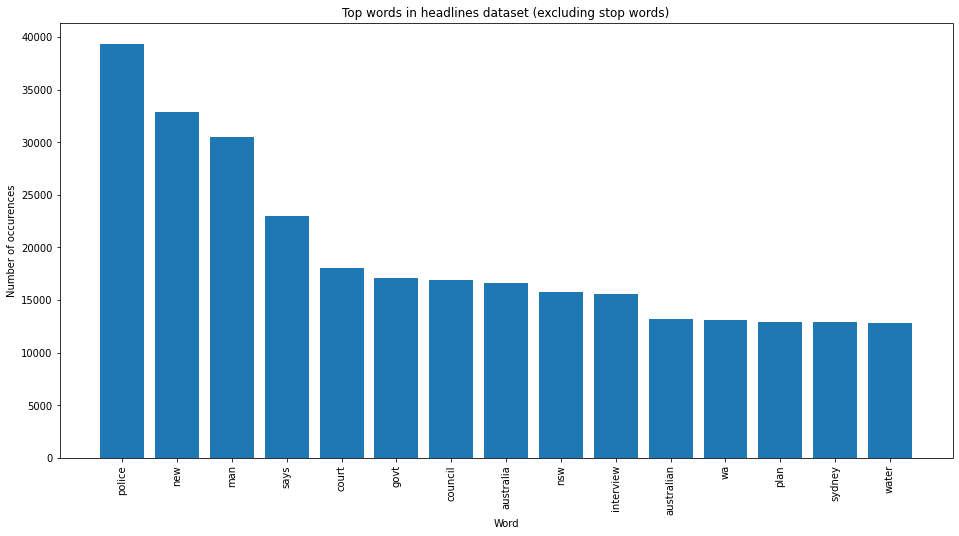

In [ ]:
count_vectorizer = CountVectorizer(stop_words='english')
words, word_values = get_top_n_words(n_top_words=15,
                                     count_vectorizer=count_vectorizer, 
                                     text_data=reindexed_data)

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values)
ax.set_xticks(range(len(words)))
ax.set_xticklabels(words, rotation='vertical')
ax.set_title('Top words in headlines dataset (excluding stop words)')
ax.set_xlabel('Word')
ax.set_ylabel('Number of occurences')
plt.show()

In [ ]:
small_count_vectorizer = CountVectorizer(stop_words='english', max_features=4000)
small_text_sample = reindexed_data.sample(n=10000, random_state=0).values

print('Headline before vectorization: {}'.format(small_text_sample[123]))

small_document_term_matrix = small_count_vectorizer.fit_transform(small_text_sample)

print('Headline after vectorization: \n{}'.format(small_document_term_matrix[123]))

Headline before vectorization: man jailed for theft of police files
Headline after vectorization: 
  (0, 2196)	1
  (0, 2662)	1
  (0, 1917)	1
  (0, 3596)	1


## <b>Latent Dirichlet Allocation</b>

### LDA is a generative probabilistic process, designed with the specific goal of uncovering latent topic structure in text corpora.

In [ ]:
# Parameters tuning using Grid Search
from sklearn.model_selection import GridSearchCV
grid_params = {'n_components' : list(range(5,10))}

# LDA model
lda = LatentDirichletAllocation()
lda_model = GridSearchCV(lda,param_grid=grid_params)
lda_model.fit(small_document_term_matrix)

# Best LDA model
best_lda_model = lda_model.best_estimator_

print("Best LDA model's params" , lda_model.best_params_)
print("Best log likelihood Score for the LDA model",lda_model.best_score_)
print("LDA model Perplexity on train data", best_lda_model.perplexity(small_document_term_matrix))

Best LDA model's params {'n_components': 5}
Best log likelihood Score for the LDA model -82833.39960387566
LDA model Perplexity on train data 3971.524566909394


### Once again, we take the $\arg \max$ of each entry in the topic matrix to obtain the predicted topic category for each headline. These topic categories can then be characterised by their most frequent words.


In [ ]:
!pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 36.8 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=ff277a97ea78f669793892414a5b583a5f1b12f6180287c84e7efacf471d4ebd
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1310 sha256=d60d30ce0577d97bf32b7b379fb911a6065d4cb71dbada34936ccd69c76da163
  Stored in directory: /root/.cache/pip/wheels/46/ef/c3/157e41f5ee1372d1be90b09f74f82b10e391eaacca8f22d33e
Successfully built pyLDAvis sklearn


In [ ]:
import pyLDAvis.sklearn

pyLDAvis.enable_notebook()

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping


In [ ]:
lda_panel = pyLDAvis.sklearn.prepare(best_lda_model, small_document_term_matrix,small_count_vectorizer,mds='tsne')
lda_panel

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:827: FutureWarning: 'square_distan

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
1      150.222153  -72.269554       1        1  21.209045
3       51.163364 -159.968018       2        1  20.829705
4      -73.144554   21.523815       3        1  20.655454
0      -66.410133 -110.606438       4        1  18.661119
2       54.417324   12.443444       5        1  18.644677, topic_info=           Term        Freq       Total Category  logprob  loglift
1872  interview  105.000000  105.000000  Default  30.0000  30.0000
2662     police  304.000000  304.000000  Default  29.0000  29.0000
2411        new  244.000000  244.000000  Default  28.0000  28.0000
1595       govt  121.000000  121.000000  Default  27.0000  27.0000
2365     murder   88.000000   88.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
288   australia   33.187759  134.028854   Topic5  -5.4477   0.2837
2803        qld   30.083837   97.457355   Topic5  -5.5459   0.5042
995        deal   23.022239   55.605543   Topic5  -5.8134   0.7978
2629       plan   23.776529  103.915596   Topic5  -5.7812   0.2047
3090      rural   22.911110   70.484166   Topic5  -5.8183   0.5558

[323 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
37        5  0.912205        25
61        2  0.161837       abc
61        4  0.829414       abc
72        4  0.960598  accident
75        1  0.257058   accused
...     ...       ...       ...
3987      5  0.331005      year
3992      4  0.970374      york
3993      2  0.165902     young
3993      5  0.829511     young
3994      1  0.962482     youth

[496 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 5, 1, 3])